In [1]:
import pickle
from natsort import natsorted

basedir = '../../ImageNomer/data/anton/cohorts/PNC'
demoname = f'{basedir}/demographics.pkl'

with open(demoname, 'rb') as f:
    demo = pickle.load(f)
    
subs = natsorted(list(demo['age_at_cnb'].keys()))
print(len(subs))

1529


In [2]:
import numpy as np

basis_file = '/home/anton/Documents/Tulane/Research/PNC_Good/AngleBasis1.pkl'
basis = pickle.load(open(basis_file, 'rb'))

# FC, age, sex, race, thetas, jitter
rest = [[],[],[],[],[],[]]
nback = [[],[],[],[],[],[]]
emoid = [[],[],[],[],[],[]]

for sub in subs:
    for task, struct in zip(['rest', 'nback', 'emoid'], [rest, nback, emoid]):
        try:
            if demo['Race'][sub] not in ['AA', 'EA']:
                continue
            p = np.load(f'{basedir}/fc/{sub}_task-{task}_fc.npy')
            a = demo['age_at_cnb'][sub]
            s = demo['Sex'][sub] == 'M'
            r = demo['Race'][sub] == 'AA'
            ab = basis[f'{sub}-{task}']
            struct[1].append(a)
            struct[2].append(s)
            struct[3].append(r)
            struct[0].append(p)
            struct[4].append(ab['thetas'])
            struct[5].append(ab['jitter'])
        except:
            continue
    
for struct in [rest, nback, emoid]:
    struct[0] = np.stack(struct[0])
    struct[1] = np.array(struct[1])
    struct[2] = np.array(struct[2]).astype('int')
    struct[3] = np.array(struct[3]).astype('int')
    struct[4] = np.stack(struct[4])
    struct[5] = np.stack(struct[5])
    
    print([a.shape for a in struct])


[(1230, 34716), (1230,), (1230,), (1230,), (1230, 1, 264), (1230, 1, 264)]
[(1290, 34716), (1290,), (1290,), (1290,), (1290, 1, 264), (1290, 1, 264)]
[(1329, 34716), (1329,), (1329,), (1329,), (1329, 1, 264), (1329, 1, 264)]


In [43]:
def rmse(yhat, y):
    if isinstance(yhat, np.ndarray) or isinstance(yhat, int):
        f = np.mean
    else:
        f = torch.mean
    return f((y-yhat)**2)**0.5

def tops(thetas, jitter):
    t0 = np.expand_dims(thetas, 2)
    t1 = np.expand_dims(thetas, 3)
    j0 = np.expand_dims(jitter, 2)
    j1 = np.expand_dims(jitter, 3)
    ps = np.cos(t0-t1)*(j0*j1)
    a,b = np.triu_indices(264, 1)
    ps = ps[:,:,a,b]
    return ps
    
for st in [rest, nback, emoid]:
    ps = tops(st[4], st[5])
    aps = np.mean(ps, axis=1)
    res = st[0] - aps

    print(ps.shape)
    print(aps.shape)
    print(res.shape)
    
    st.append(aps)
    st.append(res)
    print(len(st))

(1230, 1, 34716)
(1230, 34716)
(1230, 34716)
8
(1290, 1, 34716)
(1290, 34716)
(1290, 34716)
8
(1329, 1, 34716)
(1329, 34716)
(1329, 34716)
8


In [11]:
# Try residual PCA and Factor analysis

from sklearn.decomposition import PCA, FactorAnalysis

for st in [rest, nback, emoid]:
    pca = PCA(n_components=10).fit(st[0])
    low = pca.inverse_transform(pca.transform(st[0]))
    res = st[0]-low
    st.append(res)
    
    fa = FactorAnalysis(n_components=10).fit(st[0])
    low = fa.transform(st[0])@fa.components_
    res = st[0]-low
    st.append(res)
    
    print(len(st))

10
10
10


In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

def cat(x, **kwargs):
    return np.concatenate(x, **kwargs)

accs0, accs1, accs2 = [], [], []

mod1 = emoid
mod2 = rest

for _ in range(10):
    x = cat([mod1[7], mod2[7]], axis=0)
    z = cat([mod1[6], mod2[6]], axis=0)
    w = cat([mod1[0], mod2[0]], axis=0)
    y = cat([np.zeros(mod1[7].shape[0]), np.ones(mod2[7].shape[0])], axis=0)

    xtr, xt, ztr, zt, wtr, wt, ytr, yt = train_test_split(x, z, w, y, stratify=y, train_size=0.5)

    reg = LogisticRegression(C=1, max_iter=1000).fit(xtr, ytr)
    yhat = reg.predict(xt)
    acc = np.mean(yhat == yt)
    print(acc)
    accs0.append(acc)
    
#     reg = LogisticRegression(C=1, max_iter=1000).fit(ztr, ytr)
#     yhat = reg.predict(zt)
#     acc = np.mean(yhat == yt)
#     print(acc)
#     accs1.append(acc)
    
#     reg = LogisticRegression(C=1, max_iter=1000).fit(wtr, ytr)
#     yhat = reg.predict(wt)
#     acc = np.mean(yhat == yt)
#     print(acc)
#     accs2.append(acc)
    
print('---')
for a in [accs0, accs1, accs2]:
    print(np.mean(a), np.std(a))

0.92578125
0.9328125
0.9265625
0.9203125
0.92734375


KeyboardInterrupt: 

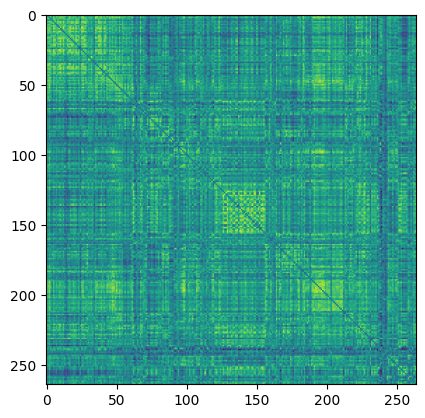

In [38]:
import matplotlib.pyplot as plt

plt.imshow(remap(vec2mat(nback[9][8])))
plt.show()

In [13]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete
